In [35]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import gseapy as gp
from sklearn.metrics import adjusted_rand_score, classification_report
from singleR import annotate_with_singler

In [36]:
import torch, numpy as np, random
seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


In [37]:
import scanpy as sc

ST_full = sc.read_h5ad('/data/keerthana/integration/scMODAL/xenium_breast_cancer.h5ad')
ST_full.var_names_make_unique()
SC_full = sc.read_h5ad('/data/keerthana/integration/scMODAL/xenium_sc_data.h5ad')
SC_full.var_names_make_unique()

#subset
N_A = 2000
N_B = 2000

# Set a seed for reproducibility
rng = np.random.default_rng(seed=42)

A_idx = rng.choice(ST_full.n_obs, size=N_A, replace=False)
B_idx = rng.choice(SC_full.n_obs, size=N_B, replace=False)

ST = ST_full[A_idx].copy()
SC = SC_full[B_idx].copy()

In [38]:
import pandas as pd

# Define mapping from fine-grained ST types to major SC types
mapping = {
    # Lymphoid
    'B_Cells': 'B-cells',
    'CD4+_T_Cells': 'T-cells',
    'CD8+_T_Cells': 'T-cells',
    'Stromal_&_T_Cell_Hybrid': 'T-cells',
    'T_Cell_&_Tumor_Hybrid': 'T-cells',

    # Myeloid
    'Macrophages_1': 'Myeloid',
    'Macrophages_2': 'Myeloid',
    'Mast_Cells': 'Myeloid',
    'IRF7+_DCs': 'Myeloid',
    'LAMP3+_DCs': 'Myeloid',
    'TFR+_DCs': 'Myeloid',

    # Epithelial
    'Invasive_Tumor': 'Cancer Epithelial',
    'Prolif_Invasive_Tumor': 'Cancer Epithelial',
    'DCIS_1': 'Cancer Epithelial',
    'DCIS_2': 'Cancer Epithelial',
    'Myoepi_ACTA2+': 'Normal Epithelial',
    'Myoepi_KRT15+': 'Normal Epithelial',

    # Endothelial
    'Endothelial': 'Endothelial',
    'Perivascular-Like': 'Endothelial',

    # Stromal
    'Stromal': 'CAFs',

    # Unlabeled / others
    'Unlabeled': 'Unlabeled'
}

# Apply mapping
ST.obs['celltype_major'] = ST.obs['cell_type'].map(mapping)

# If any fine types weren't mapped
unmapped = ST.obs.loc[ST.obs['celltype_major'].isna(), 'cell_type'].unique()
if len(unmapped) > 0:
    print("Unmapped cell types:", unmapped)
else:
    print("✅ All cell types mapped successfully!")



✅ All cell types mapped successfully!


In [39]:
# Reorder ST and SC so that common columns are first and in the same order
shared_genes = [g for g in ST.var_names if g in SC.var_names]  # preserves ST order
ST = ST[:, shared_genes]
SC = SC[:, shared_genes]

# keep track of common_vars length
common_vars = shared_genes
shared_gene_num = len(common_vars)



In [40]:
ST.shape, SC.shape

((2000, 308), (2000, 308))

## spatialmodal training

In [41]:
import scmodal
model = scmodal.model.Model(training_steps=100)
model.preprocess(ST,SC, shared_gene_num= shared_gene_num,alpha = None, eta = None)

preprocess called with alpha: None and eta: None
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [42]:
model.train()

Begining time:  Thu Nov 27 15:54:34 2025
step 0, loss_D=0.053221, loss_GAN=-0.046050, loss_AE=359.125610, loss_Geo=-14.648248, loss_LA=2174.932617, loss_MNN=53.552708
Ending time:  Thu Nov 27 15:54:41 2025
Training takes 6.54 seconds


In [43]:
model.eval()

Begining time:  Thu Nov 27 15:54:41 2025
Ending time:  Thu Nov 27 15:54:41 2025
Evaluating takes 0.10 seconds


In [44]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

def impute_cell_types(model, ST, SC, n_neighbors=10):
    emb_A = model.latent[:ST.shape[0], :]
    emb_B = model.latent[ST.shape[0]:, :]

    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine').fit(emb_B)
    knn_idx = nbrs.kneighbors(emb_A, return_distance=False)

    # Factorize string labels to numeric
    labels = np.array(SC.obs["celltype_major"].values)
    codes, uniques = pd.factorize(labels)
    neighbor_codes = codes[knn_idx]

    # Majority vote using bincount (fast + numeric)
    majority_idx = np.apply_along_axis(lambda x: np.bincount(x).argmax(), 1, neighbor_codes)
    majority_labels = uniques[majority_idx]

    ST.obs["imputed_cell_type"] = majority_labels
    return ST


In [45]:
import pandas as pd
import numpy as np
import os
import subprocess

# Save reference labels
SC.obs["celltype_major"].to_csv("temp/ref_labels.csv", index=False, header=False)

def predict_singleR( model, tmpdir = "temp"):
    

    tmpdir = tmpdir
    os.makedirs(tmpdir, exist_ok=True)
    
    # Extract latent matrices
    emb_A = model.latent[:ST.shape[0], :]      # query
    emb_B = model.latent[ST.shape[0]:, :]      # reference
    
    
    # TRANSPOSE for SingleR format: genes × cells
    sc_mat  = emb_A.T
    ref_mat = emb_B.T
    
    # Load the common gene names you used
    dummy_features = [str(i) for i in range(1, sc_mat.shape[0] + 1)]
    
    # Save with gene names
    pd.DataFrame(sc_mat, index=dummy_features).to_csv(f"{tmpdir}/query.csv")
    pd.DataFrame(ref_mat, index=dummy_features).to_csv(f"{tmpdir}/ref.csv")
    subprocess.run(["Rscript", "run_singler.R", "temp"], check=True)

 


In [46]:
predict_singleR(model,"temp")

preds = pd.read_csv("temp/predictions.csv", header=0)
ST.obs["SingleR_pred"] = preds.values[:, 0]




[1] "Number of DE genes:20"
[1] "Number of cells: 2000"
[1] "Fine-tuning round on top cell types (using 16 CPU cores):"


In [47]:
ari = adjusted_rand_score(ST.obs['celltype_major'], ST.obs['SingleR_pred'])
ari

0.59531630032884

In [48]:
# ST = annotate_with_singler(
#     model=model,  # optional
#     ST=ST, 
#     SC=SC, 
#     cell_type_column="celltype_major",
#     fine_tune=True,
#     use_embeddings=True  # Set True to use model.latent like KNN
# )
# ari = adjusted_rand_score(ST.obs['celltype_major'], ST.obs['singler_cell_type'])
# ari

In [49]:
ST = impute_cell_types(model, ST, SC, n_neighbors=10)
print(len(np.unique(ST.obs['imputed_cell_type'])))
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(ST.obs['celltype_major'], ST.obs['imputed_cell_type'])
ari

9


0.5967277368991206

In [50]:
#actual loop starts here - now that we have first guess of cell types

In [51]:
# --- ensure counts layer is present and sample is categorical string ---
if "counts" not in ST.layers:
    ST.layers["counts"] = ST.X.copy()
# make sure sample is a category
ST.obs["sample"] = ST.obs.get("sample", "sample_1")
ST.obs["sample"] = ST.obs["sample"].astype(str).astype("category")

In [52]:
import scvi
import scanpy as sc
from scvi.external import SCVIVA
import logging

scvi.settings.seed = 42
scvi.settings.verbosity = logging.CRITICAL

scvi.model.SCVI.setup_anndata(
    ST,
    layer="counts",            # raw counts for modeling
    batch_key="sample",        # if you have one batch, set to a constant
    labels_key="SingleR_pred",    # for SCANVI later
)

# 4. Train SCVI
vae = scvi.model.SCVI(ST)
vae.train(max_epochs=200)

scanvi_model = scvi.model.SCANVI.from_scvi_model(vae, unlabeled_category="Unknown")
scanvi_model.train(max_epochs=100)

ST.obsm["X_scANVI"] = scanvi_model.get_latent_representation()

setup_kwargs = {
        # "sample_key": "sample",  # column in adata.obs that contains the individual slide ID
        "labels_key": "SingleR_pred",  # column in adata.obs that contains the cell type labels
        "cell_coordinates_key": "spatial",  # spatial coordinates key in adata.obsm
        "expression_embedding_key": "X_scANVI",  # expression embedding key in adata.obsm
        "sample_key": "sample"
    }
scvi.external.SCVIVA.preprocessing_anndata(
    ST,
    k_nn=20,  # number of nearest neighbors for spatial graph construction
    **setup_kwargs,
)
scvi.external.SCVIVA.setup_anndata(
    ST,
    layer="counts",  # adata layer that contains the raw counts
    batch_key="sample",  # column in adata.obs that contains the batch covariate
    **setup_kwargs,
)

nichevae = scvi.external.SCVIVA(ST, gene_likelihood="zinb")

Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Saved niche_indexes and niche_distances in adata.obsm

Saved niche_composition in adata.obsm

Saved niche_activation in adata.obsm

In [53]:
n_iter = 9

In [55]:
ckpt = "scviva_ckpt"

aris = []
for i in range(n_iter):
    print(f"🔄 Iteration {i+1}/{n_iter}")

    # 1. INIT (1st iteration) or LOAD (later iterations)
    if i == 0:
        scvi.external.SCVIVA.setup_anndata(
            ST,
            layer="counts",
            batch_key="sample",
            **setup_kwargs,
        )
        nichevae = scvi.external.SCVIVA(ST, gene_likelihood="zinb")
    else:
        # Load SCVIVA from checkpoint
        nichevae = scvi.external.SCVIVA.load(ckpt, ST)


    # 2. TRAIN SCVIVA
    nichevae.train(
        max_epochs=50,
        early_stopping=True,
        batch_size=min(512, ST.shape[0]),
        plan_kwargs={
            "lr": 5e-4,
        },
    )

    # 3. SAVE CHECKPOINT
    nichevae.save(ckpt, overwrite=True)

    # 4. UPDATE LATENT ("η")
    ST.obsm["X_scVIVA"] = nichevae.get_latent_representation()
    ST.obsm["X_scVIVA"] = pd.DataFrame(ST.obsm["X_scVIVA"], index=ST.obs.index)

    # 5. UPDATE NIHCHEVAE ("α", "η") INTO YOUR MODEL
    alpha = ST.obsm['niche_composition']
    eta = ST.obsm["X_scVIVA"]
    model.update_embeddings(alpha=alpha, eta=eta)

    # 6. TRAIN DOWNSTREAM MODEL (INITIALIZE ONLY ON FIRST ITERATION)
    if i == 0:
        model.train(load_ckpt=False)
    else:
        model.train(load_ckpt=True)
    model.eval()

    predict_singleR(model, "temp")

    preds = pd.read_csv("temp/predictions.csv", header=0)
    ST.obs["SingleR_pred"] = preds.values[:, 0]


    # 8. Evaluate ARI
    ari = adjusted_rand_score(ST.obs['celltype_major'], ST.obs['SingleR_pred'])
    aris.append(ari)
    print(f"Iteration ARI: {ari}")

    prev_ari = ari


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


🔄 Iteration 1/9


Training:   0%|          | 0/50 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


✅ Updated alpha and eta embeddings in the model (weights preserved).
Begining time:  Thu Nov 27 16:03:17 2025
step 0, loss_D=0.259763, loss_GAN=-0.219192, loss_AE=140.911392, loss_Geo=-16.774704, loss_LA=805.343933, loss_MNN=16.659311
Ending time:  Thu Nov 27 16:03:23 2025
Training takes 6.85 seconds
Begining time:  Thu Nov 27 16:03:24 2025
Ending time:  Thu Nov 27 16:03:24 2025
Evaluating takes 0.15 seconds
[1] "Number of DE genes:20"
[1] "Number of cells: 2000"
[1] "Fine-tuning round on top cell types (using 16 CPU cores):"


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Iteration ARI: 0.6412542265438781
🔄 Iteration 2/9


Training:   0%|          | 0/50 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


✅ Updated alpha and eta embeddings in the model (weights preserved).
Begining time:  Thu Nov 27 16:03:57 2025
🧩 Loading checkpoint with shape-safe mapping...
⚠️ Skipping optimizer_G load due to mismatch: local variable 'optimizer_G' referenced before assignment
⚠️ Skipping optimizer_D load due to mismatch: local variable 'optimizer_D' referenced before assignment
step 0, loss_D=0.570007, loss_GAN=-0.516028, loss_AE=18.656429, loss_Geo=-18.787420, loss_LA=1.685074, loss_MNN=2.030598
Ending time:  Thu Nov 27 16:04:05 2025
Training takes 7.12 seconds
Begining time:  Thu Nov 27 16:04:05 2025
Ending time:  Thu Nov 27 16:04:05 2025
Evaluating takes 0.09 seconds
[1] "Number of DE genes:20"
[1] "Number of cells: 2000"
[1] "Fine-tuning round on top cell types (using 16 CPU cores):"


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Iteration ARI: 0.5717340669825416
🔄 Iteration 3/9


Training:   0%|          | 0/50 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


✅ Updated alpha and eta embeddings in the model (weights preserved).
Begining time:  Thu Nov 27 16:04:36 2025
🧩 Loading checkpoint with shape-safe mapping...
⚠️ Skipping optimizer_G load due to mismatch: local variable 'optimizer_G' referenced before assignment
⚠️ Skipping optimizer_D load due to mismatch: local variable 'optimizer_D' referenced before assignment
step 0, loss_D=0.469195, loss_GAN=-0.431244, loss_AE=12.758895, loss_Geo=-18.907604, loss_LA=0.829102, loss_MNN=1.732178
Ending time:  Thu Nov 27 16:04:43 2025
Training takes 7.12 seconds
Begining time:  Thu Nov 27 16:04:43 2025
Ending time:  Thu Nov 27 16:04:43 2025
Evaluating takes 0.11 seconds
[1] "Number of DE genes:20"
[1] "Number of cells: 2000"
[1] "Fine-tuning round on top cell types (using 16 CPU cores):"


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Iteration ARI: 0.6019630909997034
🔄 Iteration 4/9


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 271.664. Signaling Trainer to stop.
✅ Updated alpha and eta embeddings in the model (weights preserved).
Begining time:  Thu Nov 27 16:05:12 2025
🧩 Loading checkpoint with shape-safe mapping...
⚠️ Skipping optimizer_G load due to mismatch: local variable 'optimizer_G' referenced before assignment
⚠️ Skipping optimizer_D load due to mismatch: local variable 'optimizer_D' referenced before assignment
step 0, loss_D=0.206889, loss_GAN=-0.181017, loss_AE=9.562693, loss_Geo=-19.012047, loss_LA=0.576108, loss_MNN=1.648842
Ending time:  Thu Nov 27 16:05:19 2025
Training takes 6.89 seconds
Begining time:  Thu Nov 27 16:05:19 2025
Ending time:  Thu Nov 27 16:05:20 2025
Evaluating takes 0.08 seconds
[1] "Number of DE genes:20"
[1] "Number of cells: 2000"
[1] "Fine-tuning round on top cell types (using 16 CPU cores):"


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Iteration ARI: 0.6061284377686782
🔄 Iteration 5/9


Training:   0%|          | 0/50 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


✅ Updated alpha and eta embeddings in the model (weights preserved).
Begining time:  Thu Nov 27 16:05:49 2025
🧩 Loading checkpoint with shape-safe mapping...
⚠️ Skipping optimizer_G load due to mismatch: local variable 'optimizer_G' referenced before assignment
⚠️ Skipping optimizer_D load due to mismatch: local variable 'optimizer_D' referenced before assignment
step 0, loss_D=0.219635, loss_GAN=-0.197781, loss_AE=8.926861, loss_Geo=-18.946562, loss_LA=0.462762, loss_MNN=1.704155
Ending time:  Thu Nov 27 16:05:57 2025
Training takes 7.19 seconds
Begining time:  Thu Nov 27 16:05:57 2025
Ending time:  Thu Nov 27 16:05:57 2025
Evaluating takes 0.11 seconds
[1] "Number of DE genes:20"
[1] "Number of cells: 2000"
[1] "Fine-tuning round on top cell types (using 16 CPU cores):"


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Iteration ARI: 0.540052055546333
🔄 Iteration 6/9


Training:   0%|          | 0/50 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


✅ Updated alpha and eta embeddings in the model (weights preserved).
Begining time:  Thu Nov 27 16:06:27 2025
🧩 Loading checkpoint with shape-safe mapping...
⚠️ Skipping optimizer_G load due to mismatch: local variable 'optimizer_G' referenced before assignment
⚠️ Skipping optimizer_D load due to mismatch: local variable 'optimizer_D' referenced before assignment
step 0, loss_D=0.287145, loss_GAN=-0.262063, loss_AE=8.634350, loss_Geo=-19.014677, loss_LA=0.477401, loss_MNN=1.764108
Ending time:  Thu Nov 27 16:06:35 2025
Training takes 7.28 seconds
Begining time:  Thu Nov 27 16:06:35 2025
Ending time:  Thu Nov 27 16:06:35 2025
Evaluating takes 0.11 seconds
[1] "Number of DE genes:20"
[1] "Number of cells: 2000"
[1] "Fine-tuning round on top cell types (using 16 CPU cores):"


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Iteration ARI: 0.5838740186424264
🔄 Iteration 7/9


Training:   0%|          | 0/50 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Monitored metric elbo_validation did not improve in the last 45 records. Best score: 276.967. Signaling Trainer to stop.
✅ Updated alpha and eta embeddings in the model (weights preserved).
Begining time:  Thu Nov 27 16:07:05 2025
🧩 Loading checkpoint with shape-safe mapping...
⚠️ Skipping optimizer_G load due to mismatch: local variable 'optimizer_G' referenced before assignment
⚠️ Skipping optimizer_D load due to mismatch: local variable 'optimizer_D' referenced before assignment
step 0, loss_D=0.269688, loss_GAN=-0.242679, loss_AE=7.552571, loss_Geo=-19.048365, loss_LA=0.359259, loss_MNN=1.688077
Ending time:  Thu Nov 27 16:07:12 2025
Training takes 6.73 seconds
Begining time:  Thu Nov 27 16:07:12 2025
Ending time:  Thu Nov 27 16:07:12 2025
Evaluating takes 0.07 seconds
[1] "Number of DE genes:20"
[1] "Number of cells: 2000"
[1] "Fine-tuning round on top cell types (using 16 CPU cores):"


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Iteration ARI: 0.6132262362719589
🔄 Iteration 8/9


Training:   0%|          | 0/50 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


✅ Updated alpha and eta embeddings in the model (weights preserved).
Begining time:  Thu Nov 27 16:07:43 2025
🧩 Loading checkpoint with shape-safe mapping...
⚠️ Skipping optimizer_G load due to mismatch: local variable 'optimizer_G' referenced before assignment
⚠️ Skipping optimizer_D load due to mismatch: local variable 'optimizer_D' referenced before assignment
step 0, loss_D=0.460840, loss_GAN=-0.413284, loss_AE=7.424523, loss_Geo=-19.106773, loss_LA=0.357821, loss_MNN=1.515743
Ending time:  Thu Nov 27 16:07:50 2025
Training takes 7.10 seconds
Begining time:  Thu Nov 27 16:07:50 2025
Ending time:  Thu Nov 27 16:07:50 2025
Evaluating takes 0.07 seconds
[1] "Number of DE genes:20"
[1] "Number of cells: 2000"
[1] "Fine-tuning round on top cell types (using 16 CPU cores):"


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Iteration ARI: 0.6294404769989205
🔄 Iteration 9/9


Training:   0%|          | 0/50 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


✅ Updated alpha and eta embeddings in the model (weights preserved).
Begining time:  Thu Nov 27 16:08:20 2025
🧩 Loading checkpoint with shape-safe mapping...
⚠️ Skipping optimizer_G load due to mismatch: local variable 'optimizer_G' referenced before assignment
⚠️ Skipping optimizer_D load due to mismatch: local variable 'optimizer_D' referenced before assignment
step 0, loss_D=0.601251, loss_GAN=-0.560606, loss_AE=6.805973, loss_Geo=-19.078791, loss_LA=0.314249, loss_MNN=1.447072
Ending time:  Thu Nov 27 16:08:27 2025
Training takes 7.00 seconds
Begining time:  Thu Nov 27 16:08:27 2025
Ending time:  Thu Nov 27 16:08:27 2025
Evaluating takes 0.08 seconds
[1] "Number of DE genes:20"
[1] "Number of cells: 2000"
[1] "Fine-tuning round on top cell types (using 16 CPU cores):"
Iteration ARI: 0.6421829743947691


✅ Updated alpha and eta embeddings in the model (weights preserved).
Begining time:  Thu Nov 27 03:24:03 2025
🧩 Loading checkpoint with shape-safe mapping...
⚠️ Skipping optimizer_G load due to mismatch: local variable 'optimizer_G' referenced before assignment
⚠️ Skipping optimizer_D load due to mismatch: local variable 'optimizer_D' referenced before assignment
step 0, loss_D=0.768771, loss_GAN=-0.719906, loss_AE=7.161191, loss_Geo=-19.107462, loss_LA=0.309211, loss_MNN=1.446960
Ending time:  Thu Nov 27 03:24:12 2025
Training takes 9.08 seconds
Begining time:  Thu Nov 27 03:24:12 2025
Ending time:  Thu Nov 27 03:24:13 2025
Evaluating takes 0.09 seconds
Iteration ARI: 0.6565571336198964


In [56]:
np.unique(nichevae.adata.obs['imputed_cell_type'])

array(['B-cells', 'CAFs', 'Cancer Epithelial', 'Endothelial', 'Myeloid',
       'Normal Epithelial', 'PVL', 'Plasmablasts', 'T-cells'],
      dtype=object)

In [57]:
aris

[0.6412542265438781,
 0.5717340669825416,
 0.6019630909997034,
 0.6061284377686782,
 0.540052055546333,
 0.5838740186424264,
 0.6132262362719589,
 0.6294404769989205,
 0.6421829743947691]

In [58]:
# ST = annotate_with_singler(
#     model=model,  # optional
#     ST=ST, 
#     SC=SC, 
#     cell_type_column="celltype_major",
#     fine_tune=True,
#     use_embeddings=True  # Set True to use model.latent like KNN
# )
# ari = adjusted_rand_score(ST.obs['celltype_major'], ST.obs['singler_cell_type'])
# ari

In [59]:
import pandas as pd
import numpy as np
import os

tmpdir = "temp"
os.makedirs(tmpdir, exist_ok=True)

# Extract latent matrices
emb_A = model.latent[:ST.shape[0], :]      # query
emb_B = model.latent[ST.shape[0]:, :]      # reference


# TRANSPOSE for SingleR format: genes × cells
sc_mat  = emb_A.T
ref_mat = emb_B.T

# Load the common gene names you used
dummy_features = [str(i) for i in range(1, sc_mat.shape[0] + 1)]

# Save with gene names
pd.DataFrame(sc_mat, index=dummy_features).to_csv(f"{tmpdir}/query.csv")
pd.DataFrame(ref_mat, index=dummy_features).to_csv(f"{tmpdir}/ref.csv")

# Save reference labels
SC.obs["celltype_major"].to_csv(f"{tmpdir}/ref_labels.csv", index=False, header=False)


In [60]:
import subprocess
import pandas as pd

subprocess.run(["Rscript", "run_singler.R", "temp"], check=True)

preds = pd.read_csv("temp/predictions.csv", header=0)
ST.obs["SingleR_pred"] = preds.values[:, 0]


[1] "Number of DE genes:20"
[1] "Number of cells: 2000"
[1] "Fine-tuning round on top cell types (using 16 CPU cores):"


In [61]:
from sklearn.metrics import classification_report

report = classification_report(
    ST.obs['celltype_major'],
    ST.obs['SingleR_pred']
)

print(report)

                   precision    recall  f1-score   support

          B-cells       0.33      0.73      0.45        62
             CAFs       0.95      0.70      0.80       496
Cancer Epithelial       0.93      0.85      0.88       752
      Endothelial       0.83      0.68      0.75       124
          Myeloid       0.84      0.73      0.78       175
Normal Epithelial       0.31      0.37      0.33       125
              PVL       0.00      0.00      0.00         0
     Plasmablasts       0.00      0.00      0.00         0
          T-cells       0.67      0.85      0.75       177
        Unlabeled       0.00      0.00      0.00        89

         accuracy                           0.72      2000
        macro avg       0.49      0.49      0.48      2000
     weighted avg       0.80      0.72      0.75      2000



In [62]:
from sklearn.metrics import classification_report

report = classification_report(
    ST.obs['celltype_major'],
    ST.obs['imputed_cell_type']
)

print(report)

                   precision    recall  f1-score   support

          B-cells       0.00      0.00      0.00        62
             CAFs       0.88      0.74      0.80       496
Cancer Epithelial       0.88      0.97      0.92       752
      Endothelial       0.64      0.22      0.33       124
          Myeloid       0.23      0.19      0.21       175
Normal Epithelial       0.62      0.04      0.08       125
              PVL       0.00      0.00      0.00         0
     Plasmablasts       0.00      0.00      0.00         0
          T-cells       0.26      0.75      0.39       177
        Unlabeled       0.00      0.00      0.00        89

         accuracy                           0.65      2000
        macro avg       0.35      0.29      0.27      2000
     weighted avg       0.67      0.65      0.62      2000



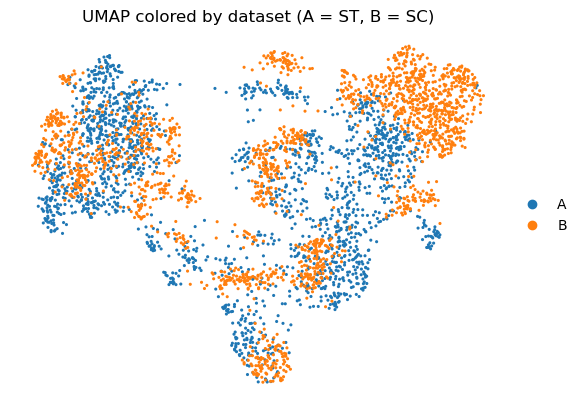

In [63]:
#plot umap of common embedding coloured by modality
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

def plot_umap_AB(model, ST, SC):
    # combined latent
    latent = model.latent

    # create a temporary AnnData to run UMAP
    from anndata import AnnData
    ad = AnnData(latent.copy())

    # assign A/B labels
    nA = ST.shape[0]
    AB_labels = np.array(["A"] * nA + ["B"] * (latent.shape[0] - nA))
    ad.obs["dataset"] = AB_labels

    # compute neighbors + UMAP
    sc.pp.neighbors(ad, use_rep=None, n_neighbors=15, metric="cosine")
    sc.tl.umap(ad)

    # plot
    sc.pl.umap(
        ad,
        color="dataset",
        title="UMAP colored by dataset (A = ST, B = SC)",
        frameon=False,
        size=20
    )
plot_umap_AB(model, ST, SC)

